### Import modules

In [166]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 1) Reading the images

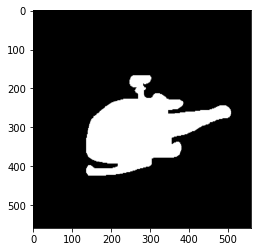

In [167]:
chopper_img = cv2.imread('chopper.png', 0)
shape_img = cv2.imread('4_1.png', 0)

plt.imshow(chopper_img, cmap='gray')
plt.show()

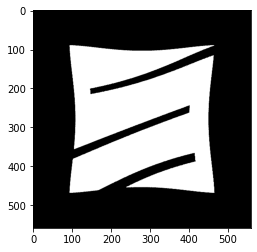

In [168]:
plt.imshow(shape_img, cmap='gray')
plt.show()

### 2) Finding boundaries

In order to find the boundaries we need to implement erosion and dilation. Erosion is the process of removing pixels at the boundaries of objects in an image. Dilation is the process of adding pixels at the boundaries of objects in an image. The following code implements erosion and dilation:

In [169]:
def erosion(img, element_size):
    element = np.ones((element_size, element_size), np.uint8)
    return cv2.erode(img, element)

def dilation(img, element_size):
    element = np.ones((element_size, element_size), np.uint8)
    return cv2.dilate(img, element)

Now we can use the difference between the eroded and dilated images to find the boundaries of the objects in the image. The following code implements the boundary finding:

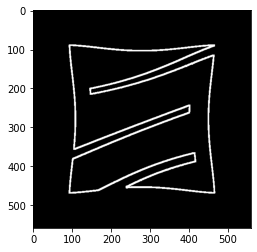

In [170]:
boundary_img = erosion(shape_img, 5) - dilation(shape_img, 5)
plt.imshow(boundary_img, cmap='gray')
plt.show()

### 3) Morphologic difference vs. subtraction

In the case of binary images, the morphologic difference is the same as the subtraction. However, in the case of grayscale images, the morphologic difference is not the same as the subtraction. The following code demonstrates the difference:

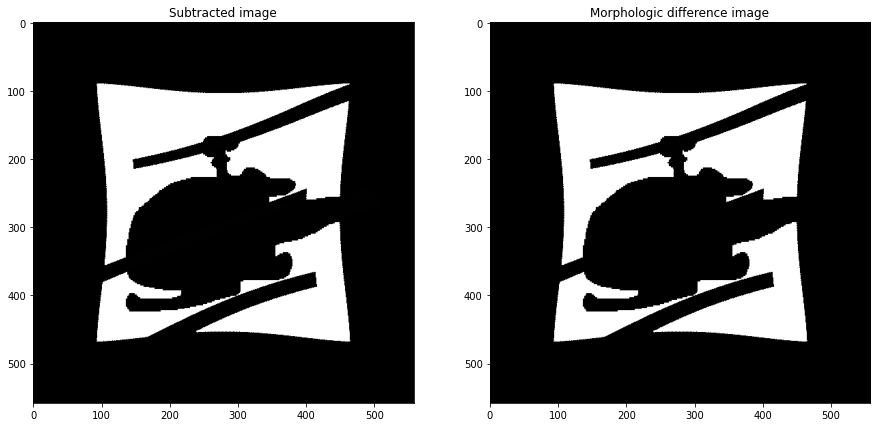

In [171]:
def morphologic_dif(img1, img2):
    new_img = np.copy(img1)
    new_img[new_img <= img2] = 0
    return new_img

subtracted_image = shape_img - chopper_img
morph_dif_image = morphologic_dif(shape_img, chopper_img)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(subtracted_image, cmap='gray')
ax[0].set_title('Subtracted image')
ax[1].imshow(morph_dif_image, cmap='gray')
ax[1].set_title('Morphologic difference image')
plt.show()

### 4) Reading the blobs images

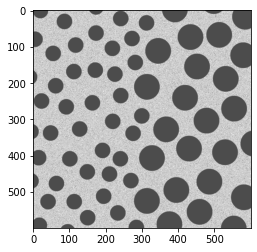

In [172]:
blobs_img = cv2.imread('blobs.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(blobs_img, cmap='gray', vmin=0, vmax=255)

### Texture segmentation

To perform texture segmentation, we should use the morphologic openning and closing. The following code implements the morphologic openning and closing with circular structuring elements:

In [173]:
def morph_open(img, radius):
    element = np.fromfunction(lambda x, y: (x - radius) ** 2 + (y - radius) ** 2 <= radius ** 2, (2 * radius + 1, 2 * radius + 1))
    element = np.array(element, dtype=np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, element)

def morph_close(img, radius):
    element = np.fromfunction(lambda x, y: (x - radius) ** 2 + (y - radius) ** 2 <= radius ** 2, (2 * radius + 1, 2 * radius + 1))
    element = np.array(element, dtype=np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, element)

At first we must use closing to remove the smaller blobs. We must choose the size of the structuring element to be large enough to remove the smaller blobs.

I found radius = 28 to be a good value for the structuring element.

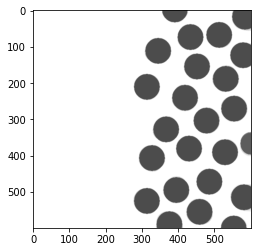

In [174]:
blobs_removed = morph_close(blobs_img, 28)
plt.imshow(blobs_removed, cmap='gray', vmin=0, vmax=255);

Then we must use openning to connect the larger blobs. We must choose the size of the structuring element to be large enough to connect the larger blobs.

I found 52 to be a good value for the structuring element.

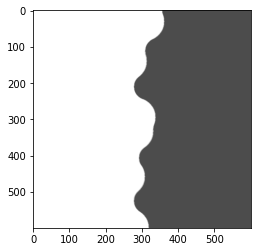

In [175]:
blobs_connected = morph_open(blobs_removed, 52)
plt.imshow(blobs_connected, cmap='gray', vmin=0, vmax=255);

Now we can use boundary finding to find the boundaries of the blobs.

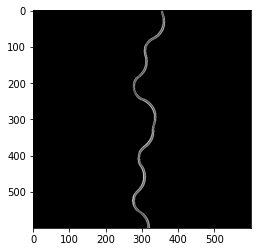

In [176]:
boundary_img = erosion(blobs_connected, 5) - dilation(blobs_connected, 3)
plt.imshow(boundary_img, cmap='gray', vmin=0, vmax=255);

Now we add the boundary to the image:

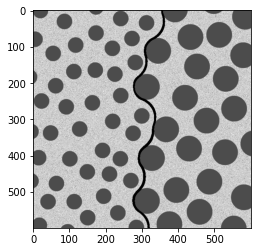

In [177]:
new_blobs_img = np.copy(blobs_img)
new_blobs_img[boundary_img > 0] = 0
plt.imshow(new_blobs_img, cmap='gray', vmin=0, vmax=255);

### Granulometry

We should perform closing operation(because of the brighter background) with different structuring element sizes and count the number of changes in each stage.

Before that, we can implement a function to count the number of transitions to 255 to count the number of changes in each stage.

In [187]:
def count_fading_pixels(img1, img2):
    '''Counts the number of pixels that change 255 in img2.'''
    count = 0
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            if img1[i, j] != 255 and img2[i, j] == 255:
                count += 1
    return count

Now we can implement the granulometry:

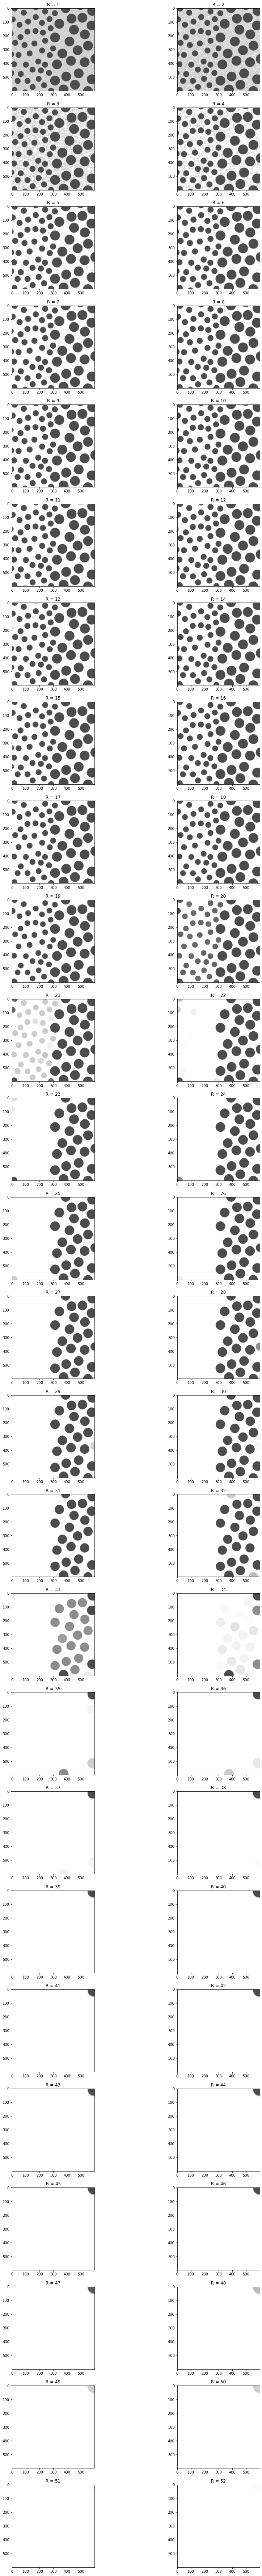

In [183]:
rs = []
changes = []
images = []
max_radius = 52
blobs_cpy = blobs_img.copy()
for radius in range(1, max_radius + 1):
    prev_image = blobs_cpy.copy()
    # closing
    blobs_cpy = morph_close(prev_image, radius)
    # appending the data
    rs.append(radius)
    changes.append(count_fading_pixels(prev_image, blobs_cpy))
    images.append(blobs_cpy)

# plotting the results
fig, ax = plt.subplots(max_radius // 2, 2, figsize=(15, 5 * max_radius // 2))
for i in range(max_radius):
    ax[i // 2, i % 2].imshow(images[i], cmap='gray', vmin=0, vmax=255)
    ax[i // 2, i % 2].set_title('R = {}'.format(rs[i]))
plt.show()

Now we can plot the number of changes vs. the size of the structuring element.

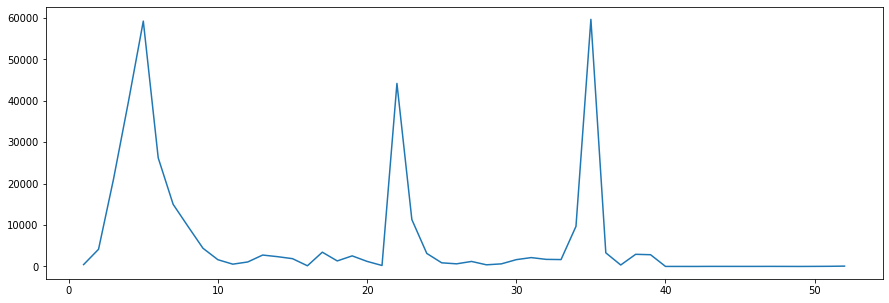

In [184]:
plt.figure(figsize=(15, 5))
plt.plot(rs, changes)
plt.show()

We can see that we have significant changes when the radius of the structuring element is 4, 22 or 35 which respectively correspond to the size of small noises, small blobs and large blobs.